- plot shap_values for 
 - models #16 and #17
 - 5 samples and 50 samples
 - public and private data
- plot attr_all_22085_genes
 - models #16 and #17
 - use same samples as above
 - public and private data
- get_plot_per_cell_type() plots attributions coloured by cell type

In [1]:
%%capture output
!pip install shap
!pip install anndata
!pip install ipywidgets
!pip install --upgrade jupyter
!pip install IProgress

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import shap

import anndata as ad
import scipy

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
import scanpy as sc
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.2 scikit-learn==1.2.2 python-igraph==0.10.4 pynndescent==0.5.8


In [3]:
# plt.rcParams['figure.dpi'] = 100

In [4]:
os.chdir('../..')

In [5]:
lrz_path = '/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/'
index_path = lrz_path + 'open-problems-multimodal-3rd-solution/input/preprocess/cite/'

In [6]:
# all_22001_genes: 22001 features, handselected_gene_ids: 84 handselected genes
all_22001_genes = np.loadtxt('2.preprocess_to_feature/cite/all_22001_genes_names.txt', dtype=str)
handselected_gene_ids = np.loadtxt('2.preprocess_to_feature/cite/handselected_84_gene_ids.txt', dtype=str)

In [7]:
# all 22085 genes sorted totally alphabetically
train_column = np.load(index_path + "train_cite_raw_inputs_idxcol.npz", allow_pickle=True)["columns"]
train_column

array(['ENSG00000121410_A1BG', 'ENSG00000268895_A1BG-AS1',
       'ENSG00000175899_A2M', ..., 'ENSG00000162378_ZYG11B',
       'ENSG00000159840_ZYX', 'ENSG00000074755_ZZEF1'], dtype=object)

### helper functions

In [8]:
# function for plotting shap values
def shap_beeswarm(shap_values, X_test, protein_idx=0):
    shap.initjs()
    shap.summary_plot(shap_values[protein_idx], X_test.to_df(), feature_names=X_test.var_names)

def shap_bar_plot(shap_values, X_test):
    shap.initjs()
    shap.summary_plot(list(shap_values), plot_type = 'bar', feature_names = X_test.var_names)
    # 140 classes = each regression output

In [9]:
# function for plotting backpropagated attribution values (new function because of other column order)
def attr_beeswarm(attr_values, X_test, protein_idx):
    # change column order to have all columns sorted and in same order as X_test
    attr_values[protein_idx] = attr_values[protein_idx].reindex(columns=train_column)
    shap.initjs()
    shap.summary_plot(np.array(attr_values[protein_idx]), X_test, feature_names=X_test.columns)

In [10]:
# get top n features from shap plots
def get_top_features(shap_values, xtest, top_n):
    shap_sum = np.abs(shap_values).sum(axis=0)
    top_features_indices = np.argsort(shap_sum)[::-1][:top_n]  # Get the indices of the top n features
    top_feature_names_shap = xtest.var_names[top_features_indices]
    return top_feature_names_shap

In [11]:
def get_gene_name(last_chars):
    return [element for element in train_column if element.split('_')[1] == last_chars]

In [12]:
get_gene_name('CD9')

['ENSG00000010278_CD9']

In [13]:
def mean_per_cell_type(attr_all_genes, xtest, n_top):
    top_feature_names_shap = get_top_features(attr_all_genes, xtest, n_top)
    # create df with shap values of top n features + cell type    
    shap_cell_types = {}
    # Add 'Cell Type' column
    shap_cell_types['Cell Type'] = xtest.obs['cell_type']
    # Add attribution values of top n features
    for feature in top_feature_names_shap:
        column_values = np.array(attr_all_genes)[:, xtest.var_names.get_loc(feature)]
        shap_cell_types[feature] = column_values

    # Create DataFrame
    shap_cell_types = pd.DataFrame(shap_cell_types)
    
    mean_per_ct = shap_cell_types.groupby('Cell Type').apply(lambda x: x.mean())  # x.abs().mean()
    mean_per_ct.reset_index(inplace=True)
    # Calculate the mean across all rows (excluding the 'cell type' column)
    overall_mean = shap_cell_types.drop('Cell Type', axis=1).mean()    # .abs().mean()
    # Add the overall mean as a new row to the DataFrame
    mean_per_ct.loc[len(mean_per_ct)] = ['Overall'] + overall_mean.tolist()
    return mean_per_ct

In [14]:
# function for plot: plot top 10 features colouring datapoints by cell type
def get_plot_per_cell_type(shap_values, xtest, protein_idx=0, n=10, show=True, save=False, filename=None, all_attr=False):   # all_attr=True if attr_all_genes passed instead of svd shap values
    
    if all_attr:
        # in this case: have 22085 columns, not totally sorted but first 22001 columns sorted and next 84 columns sorted
        # => need total order (=train_column) to match xtest
        shap_values[protein_idx] = shap_values[protein_idx].reindex(columns=train_column)

    # get top 10 features (see shap beeswarm plot)
    top_feature_names_shap = get_top_features(shap_values[protein_idx], xtest, n)
    
    # create df with shap values of top 10 features + cell type    
    shap_cell_types = {}
    for feature in top_feature_names_shap:
#         column_name = 'SHAP ' + feature.split('_')[-1]
        column_name = feature
        # column_values = shap_values[0, :, xtest.var_names.get_loc(feature)]   # use this if shap_values 3D array
        column_values = np.array(shap_values[protein_idx])[:, xtest.var_names.get_loc(feature)]   # use this if shap_values (or attr_all_22085...) dict of dataframes
        shap_cell_types[column_name] = column_values

    # Add 'Cell Type' column
    shap_cell_types['Cell Type'] = xtest.obs['cell_type']

    # Create DataFrame
    shap_cell_types = pd.DataFrame(shap_cell_types)

    # Get the mean per cell type using the mean_per_cell_type function
    mean_per_cell_type_df = mean_per_cell_type(shap_values[protein_idx], xtest, n)
    # dict to map from cell type to index in mean_per_cell_type_df
    ct_idx_map = {'BP': 0, 'EryP': 1, 'HSC': 2, 'MasP': 3, 'MkP': 4, 'MoP': 5, 'NeuP': 6}
    
    # code for actual plot:

    # Assign different colors to each class
    # colourblind palette: ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
    colors = {'BP': '#a65628', 'EryP': '#e41a1c', 'HSC': '#4daf4a', 'MasP': '#f781bf', 
              'MkP': '#377eb8', 'MoP': '#984ea3', 'NeuP': '#ff7f00'}
    # plot shap values:
    fig, ax = plt.subplots(figsize=(12, int(n*1.5)))

    # x_limit = (shap_values[protein_idx].min()-0.05, shap_values[protein_idx].max()+0.05)  # this is min and max for shap_values[protein_idx]
    x_limit = (shap_values[protein_idx].min().min()-0.05, shap_values[protein_idx].max().max()+0.05)  # above if array, this row if dict of dataframes
    
    # Remove y-axis ticks and labels
    ax.yaxis.set_visible(False)

    class_offsets = {}   # add vertical offset per class
    y = 0
    # Iterate over the columns in shap_cell_types to create subplots
    for i, column in enumerate(shap_cell_types.columns[:-1], start=1):
        ax = fig.add_subplot(len(shap_cell_types.columns)-1, 1, i)

        # Set the x-axis limits and label
        ax.set_xlim(x_limit)
        ax.set_xlabel(column)

        ax.yaxis.set_visible(False)
        
        # Get the mean value for the current column from mean_per_cell_type_df
        mean_value = mean_per_cell_type_df[column].values[:-1]  # [:-1] to exclude last row (Overall)

        # Plot the dots for the current column
        for index, row in shap_cell_types.iterrows():
            shap_value = row[column]
            class_label = row['Cell Type']
            color = colors[class_label]
            
            ##### add vertical offset per class ###
            # Check if the class_label is already in the class_offsets dictionary
            if class_label not in class_offsets:
                class_offsets[class_label] = y

            # Add the vertical offset to the y-coordinate of the dot
            y_offset = class_offsets[class_label]
            ##### add vertical offset per class ###
            
            # ax.plot(shap_value, 0, marker='o', color=color, markersize=2)  # without offset
            ax.plot(shap_value, y_offset, marker='o', color=color, markersize=2)

            # Increment the vertical offset for the next class_label
            y += 1
            
            # add vertical line showing mean per cell type
            ax.axvline(mean_value[ct_idx_map[class_label]], color=color, linestyle='solid', linewidth=2, alpha=0.8)
            
    # legend #
    legend_ax = fig.add_axes([0.45, 0.95, 0.1, 0.15])  # adjust the position and size of the legend axes

    for class_label, color in colors.items():
        legend_ax.scatter([], [], color=color, label=f'{class_label}')

    legend_ax.legend(loc='center', bbox_to_anchor=(0.5, 0.5), ncol=len(colors), frameon=False)
    legend_ax.axis('off')
    # legend #
    fig.tight_layout(rect=[0, 0.1, 0.85, 1])
            
#     fig.tight_layout(rect=[0, 0.1, 1, 1]) 
#     legend_fig.subplots_adjust(top=0.1, bottom=0.05)
    
    # save plot if save=True -> need to have filename as param
    if save:
        if filename is None:
            raise ValueError("A filename must be provided when save=True.")
        plt.savefig(f'4.model/pred/plots/{filename}.png')

    if show:
        plt.show()
    else:
        plt.close()


In [15]:
# get cell type plot for a specific gene and compare across models

def get_ct_plot_compare(attr_values_16, attr_values_17, attr_values_ensemble, xtest, protein_idx, gene):
    attr_16 = attr_values_16[protein_idx][get_gene_name(gene)].rename(columns={get_gene_name(gene)[0]: 'Model 16'})
    attr_17 = attr_values_17[protein_idx][get_gene_name(gene)].rename(columns={get_gene_name(gene)[0]: 'Model 17'})
    attr_ensemble = attr_values_ensemble[protein_idx][get_gene_name(gene)].rename(columns={get_gene_name(gene)[0]: 'Ensemble'})
    attr_df = pd.concat([attr_16, attr_17, attr_ensemble], axis=1)
    attr_df['(buffer)'] = 0
    attr_df['Cell Type'] = xtest.obs['cell_type'].reset_index(drop=True)

    # Get the mean per cell type using the mean_per_cell_type function
    mean_per_cell_type_df = attr_df.groupby('Cell Type').apply(lambda x: x.mean())
    # dict to map from cell type to index in mean_per_cell_type_df
    ct_idx_map = {'BP': 0, 'EryP': 1, 'HSC': 2, 'MasP': 3, 'MkP': 4, 'MoP': 5, 'NeuP': 6}
    
    # code for actual plot:

    # Assign different colors to each class
    # colourblind palette: ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
    colors = {'BP': '#a65628', 'EryP': '#e41a1c', 'HSC': '#4daf4a', 'MasP': '#f781bf', 
              'MkP': '#377eb8', 'MoP': '#984ea3', 'NeuP': '#ff7f00'}
    # plot shap values:
    fig, ax = plt.subplots(figsize=(8, 10))

    x_limit = (attr_df.drop('Cell Type', axis=1).min().min()-0.05, attr_df.drop('Cell Type', axis=1).max().max()+0.05)  # above if array, this row if dict of dataframes
    
    # Remove y-axis ticks and labels
    ax.yaxis.set_visible(False)

    class_offsets = {}   # add vertical offset per class
    y = 0
    # Iterate over the columns in shap_cell_types to create subplots
    for i, column in enumerate(attr_df.columns[:-1], start=1):
        ax = fig.add_subplot(len(attr_df.columns)-1, 1, i)

        # Set the x-axis limits and label
        ax.set_xlim(x_limit)
        ax.set_xlabel(column)
        
        ax.yaxis.set_visible(False)
        
        # Get the mean value for the current column from mean_per_cell_type_df
        mean_value = mean_per_cell_type_df[column]

        # Plot the dots for the current column
        for index, row in attr_df.iterrows():
            shap_value = row[column]
            class_label = row['Cell Type']
            color = colors[class_label]
            
            ##### add vertical offset per class ###
            # Check if the class_label is already in the class_offsets dictionary
            if class_label not in class_offsets:
                class_offsets[class_label] = y

            # Add the vertical offset to the y-coordinate of the dot
            y_offset = class_offsets[class_label]
            ##### add vertical offset per class ###
            
            # ax.plot(shap_value, 0, marker='o', color=color, markersize=2)  # without offset
            ax.plot(shap_value, y_offset, marker='o', color=color, markersize=2)

            # Increment the vertical offset for the next class_label
            y += 1
            
            # add vertical line showing mean per cell type
            ax.axvline(mean_value[ct_idx_map[class_label]], color=color, linestyle='solid', linewidth=2, alpha=0.8)
            
    # legend #
    legend_ax = fig.add_axes([0.45, 0.95, 0.1, 0.15])  # adjust the position and size of the legend axes

    for class_label, color in colors.items():
        legend_ax.scatter([], [], color=color, label=f'Cell type {class_label}')

    legend_ax.legend(loc='center', bbox_to_anchor=(0.5, 0.5), ncol=len(colors), frameon=False)
    legend_ax.axis('off')
    # legend #
    fig.tight_layout(rect=[0, 0.5, 0.85, 1])
    
    plt.show()

#### list of target proteins, function to get their index

In [16]:
proteins = np.load('4.model/pred/proteins.npy', allow_pickle=True)
def get_protein_idx(protein):
    return np.where(proteins == protein)[0][0]

## plots for private data

### plots for model #16

In [17]:
# shap_values = np.load('4.model/pred/shap_values_16_50_samples_p.npy', allow_pickle=True).astype(float)
shap_values = np.load('4.model/pred/shap_values_16_50_samples_p_ct_distr.npy', allow_pickle=True).astype(float)
xtest = ad.read_h5ad('4.model/pred/private_test_input_128_svd_50_samples.h5ad')
xtest

AnnData object with n_obs × n_vars = 350 × 212
    obs: 'kaggle_dataset', 'day', 'donor', 'cell_type'

In [18]:
# shap_beeswarm(shap_values, xtest)   # only svd components
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

#### shap plot with backpropagated gene attributions

In [19]:
# load private test input data (before svd)
# private_test_input instead? -> same plots, just higher feature values -> more red
private_test_input_raw = pd.read_pickle('/dss/dssfs02/lwp-dss-0001/pn36po/pn36po-dss-0001/di93zoj/kaggle/full_data/20220830_citeseq_rna_count_test_input_private_raw.pkl')
# private_test_input_raw.head()

In [20]:
# same cell ids used in xtest and SHAP:
sample_cells = np.array(xtest.obs_names)
# sample_cells[:5]

In [21]:
# create xtest_all_genes: for shap plot, containing all 22085 genes instead of svd components
# same for model 16 and 17 -> also input to ensemble shap plot
xtest_all_genes = private_test_input_raw.loc[sample_cells]
print(xtest_all_genes.shape)
# xtest_all_genes.head()

(350, 22085)


In [22]:
attr_all_22085_genes = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_16_50_samples_p_ct_distr.pkl')
attr_all_22085_genes[0].shape

(350, 22085)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


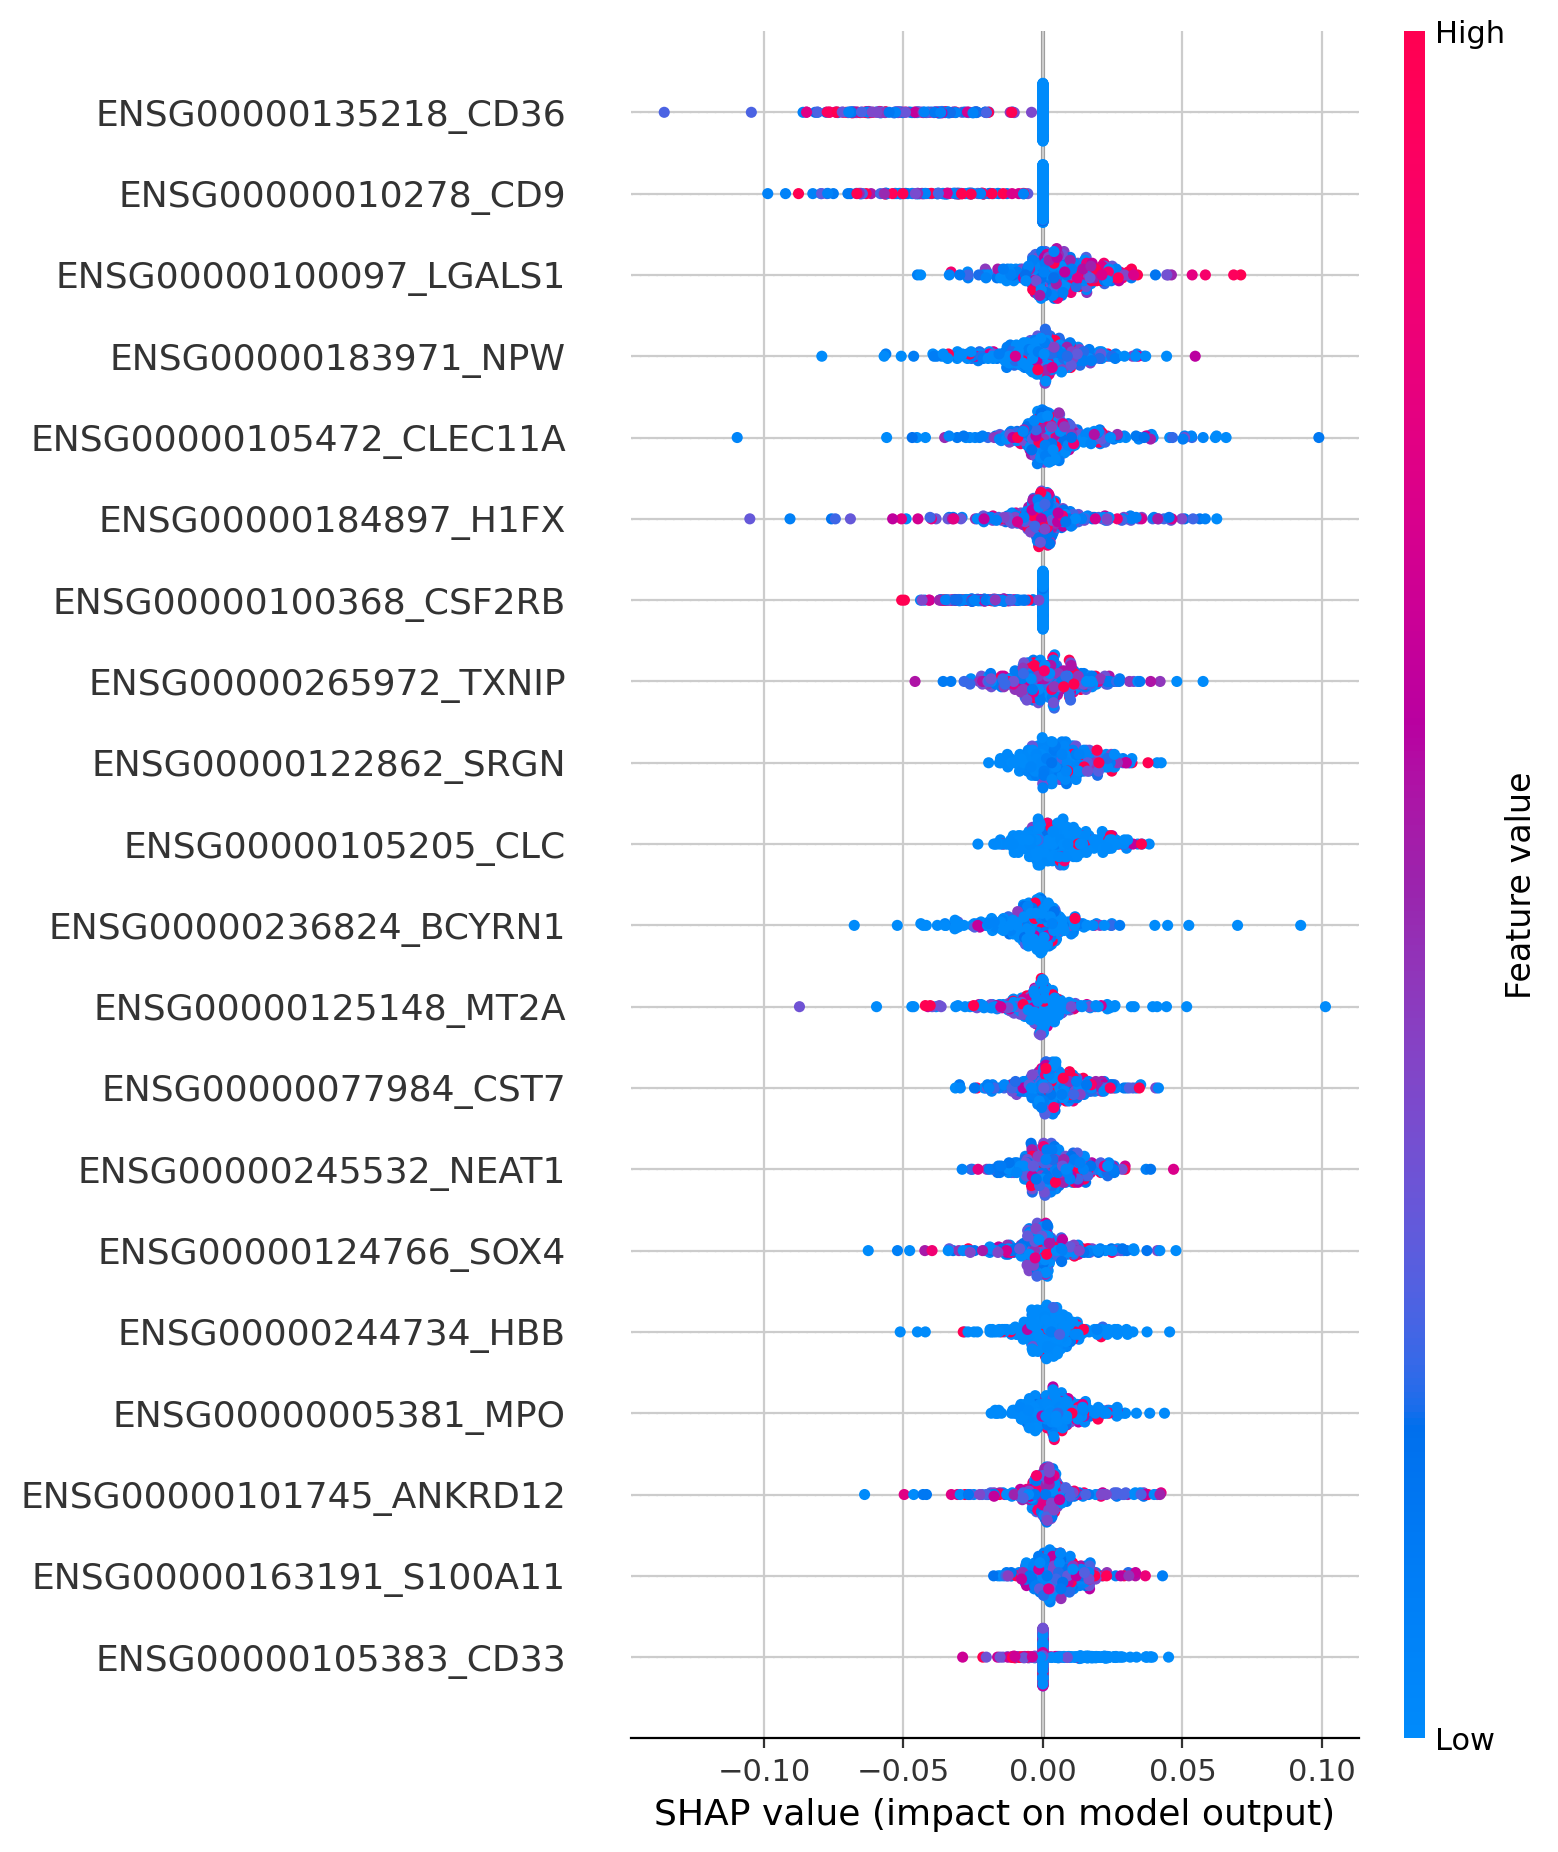

In [23]:
attr_beeswarm(attr_all_22085_genes, xtest_all_genes, get_protein_idx('CD86'))

Improve the ranking here by filtering using correlation instead of mean:

In [24]:
def corr2_coeff(A, B):
    """Row-wise pearson correlation.
    """
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    # Finally get corr coeff
    return np.diagonal(np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None])))

In [25]:
corrs = corr2_coeff(attr_all_22085_genes[get_protein_idx('CD86')].values.T, xtest_all_genes.values.T)

invalid value encountered in divide


In [26]:
pd.DataFrame(corrs, index=xtest_all_genes.columns).sort_values(by=0, ascending=False).dropna()

0
gene_ids                          
ENSG00000206531_CD200R1L  0.829280
ENSG00000114013_CD86      0.792790
ENSG00000142864_SERBP1    0.681533
ENSG00000132341_RAN       0.667725
ENSG00000134061_CD180     0.665461
...                            ...
ENSG00000105369_CD79A    -0.850268
ENSG00000173762_CD7      -0.914765
ENSG00000012124_CD22     -0.921790
ENSG00000137101_CD72     -0.940762
ENSG00000177455_CD19     -0.992561

[18809 rows x 1 columns]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


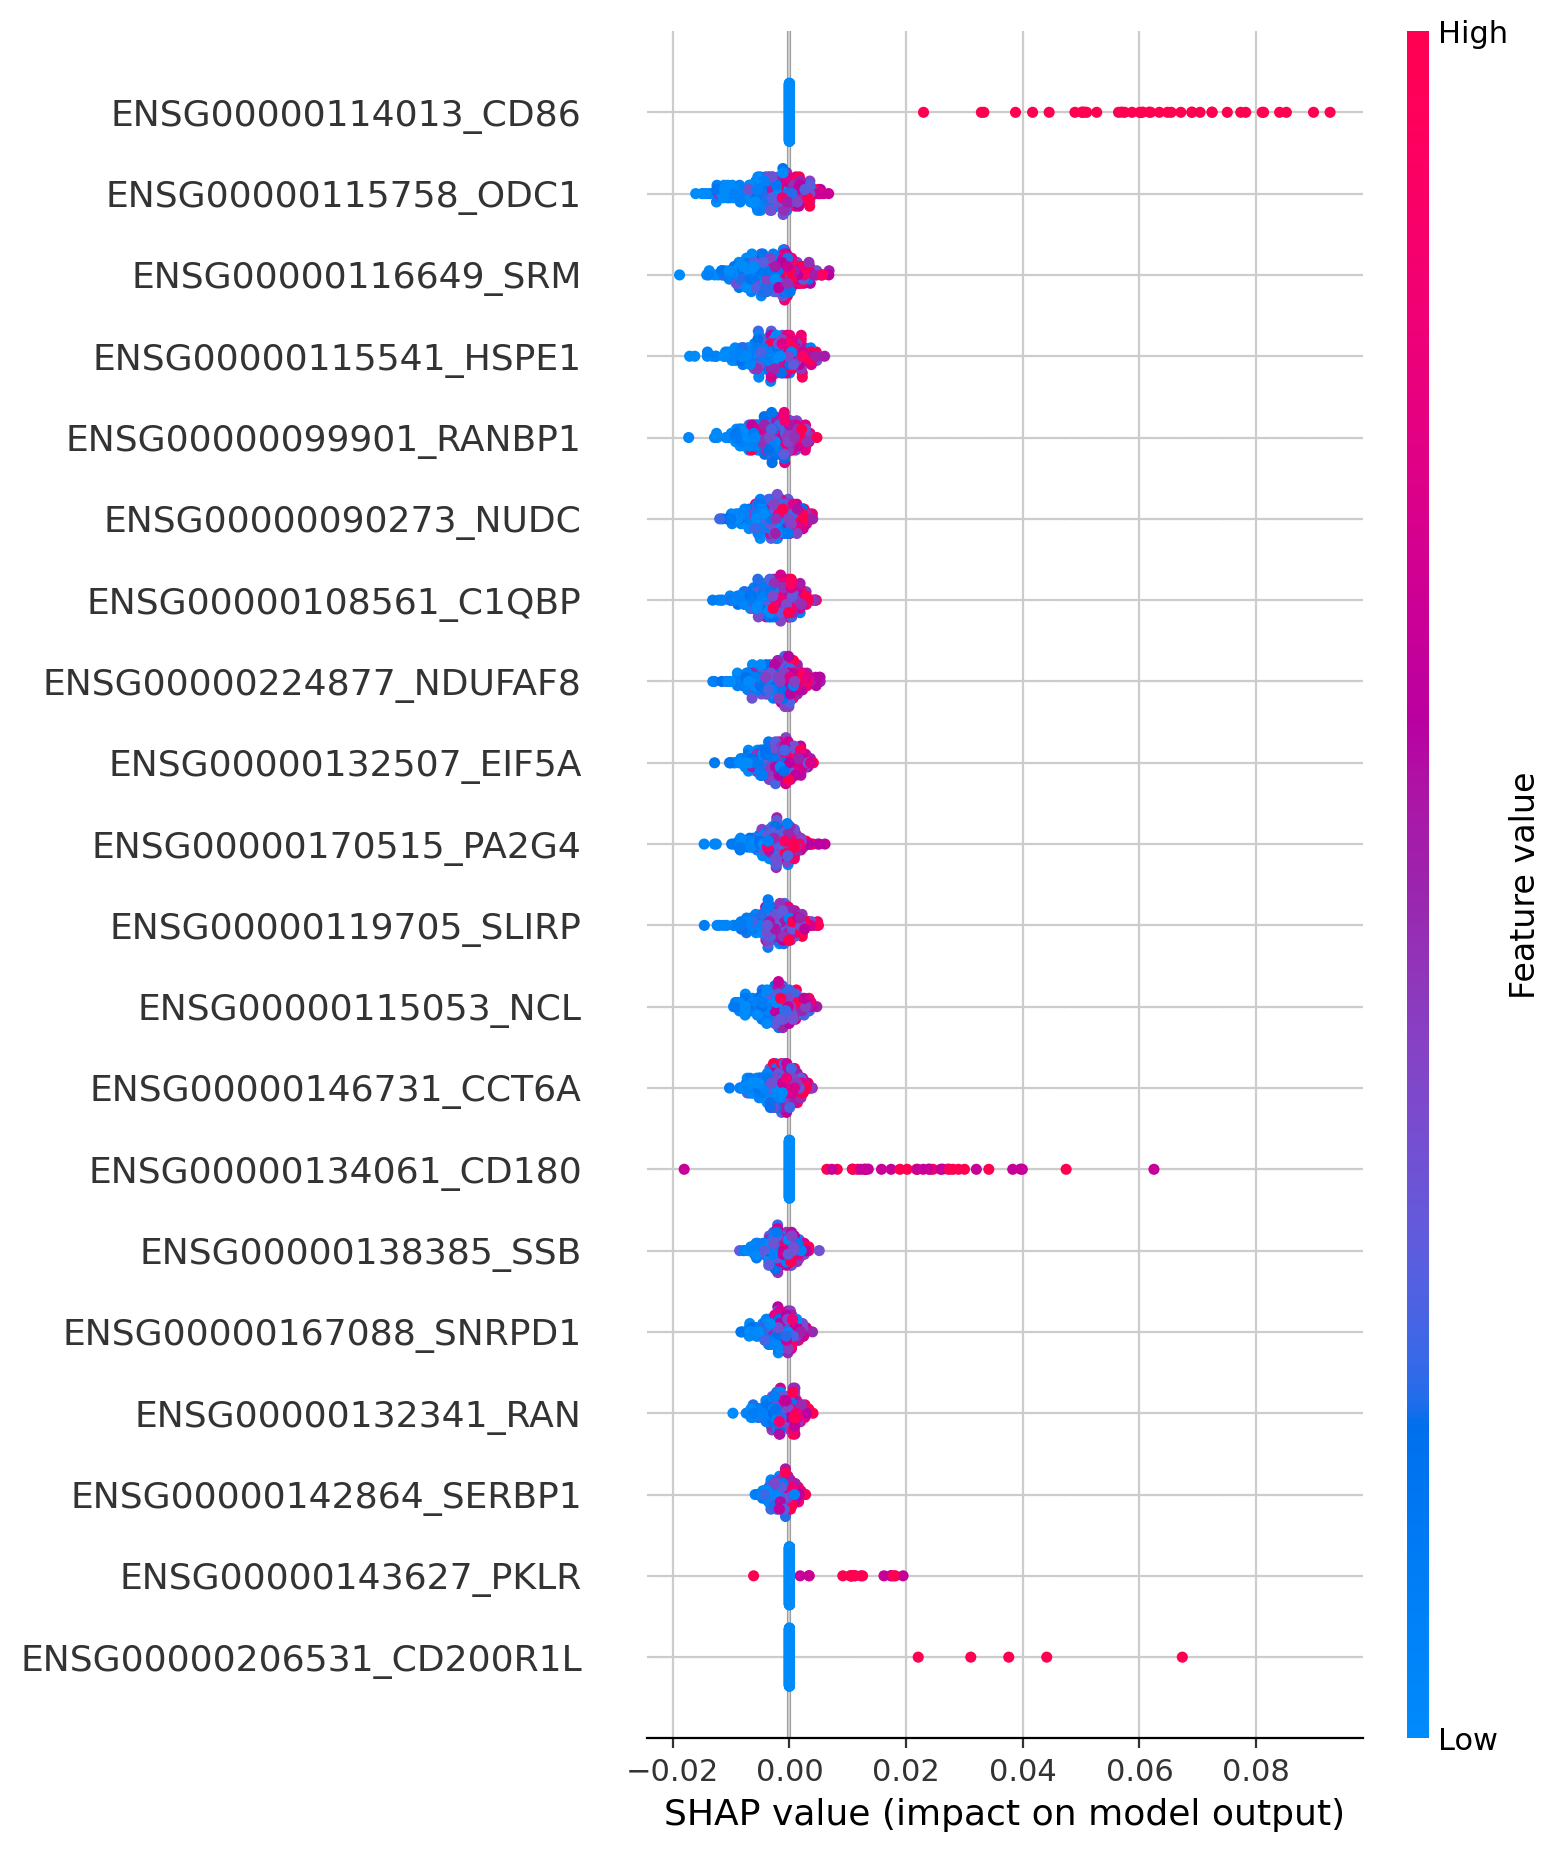

In [27]:
top_20 = list(pd.DataFrame(corrs, index=xtest_all_genes.columns).sort_values(by=0, ascending=False).dropna().index[:20])
idx = get_protein_idx('CD86')
subset = attr_all_22085_genes[idx][top_20]
shap.initjs()
shap.summary_plot(np.array(subset), xtest_all_genes[subset.columns], feature_names=subset.columns)

Bottom 20:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


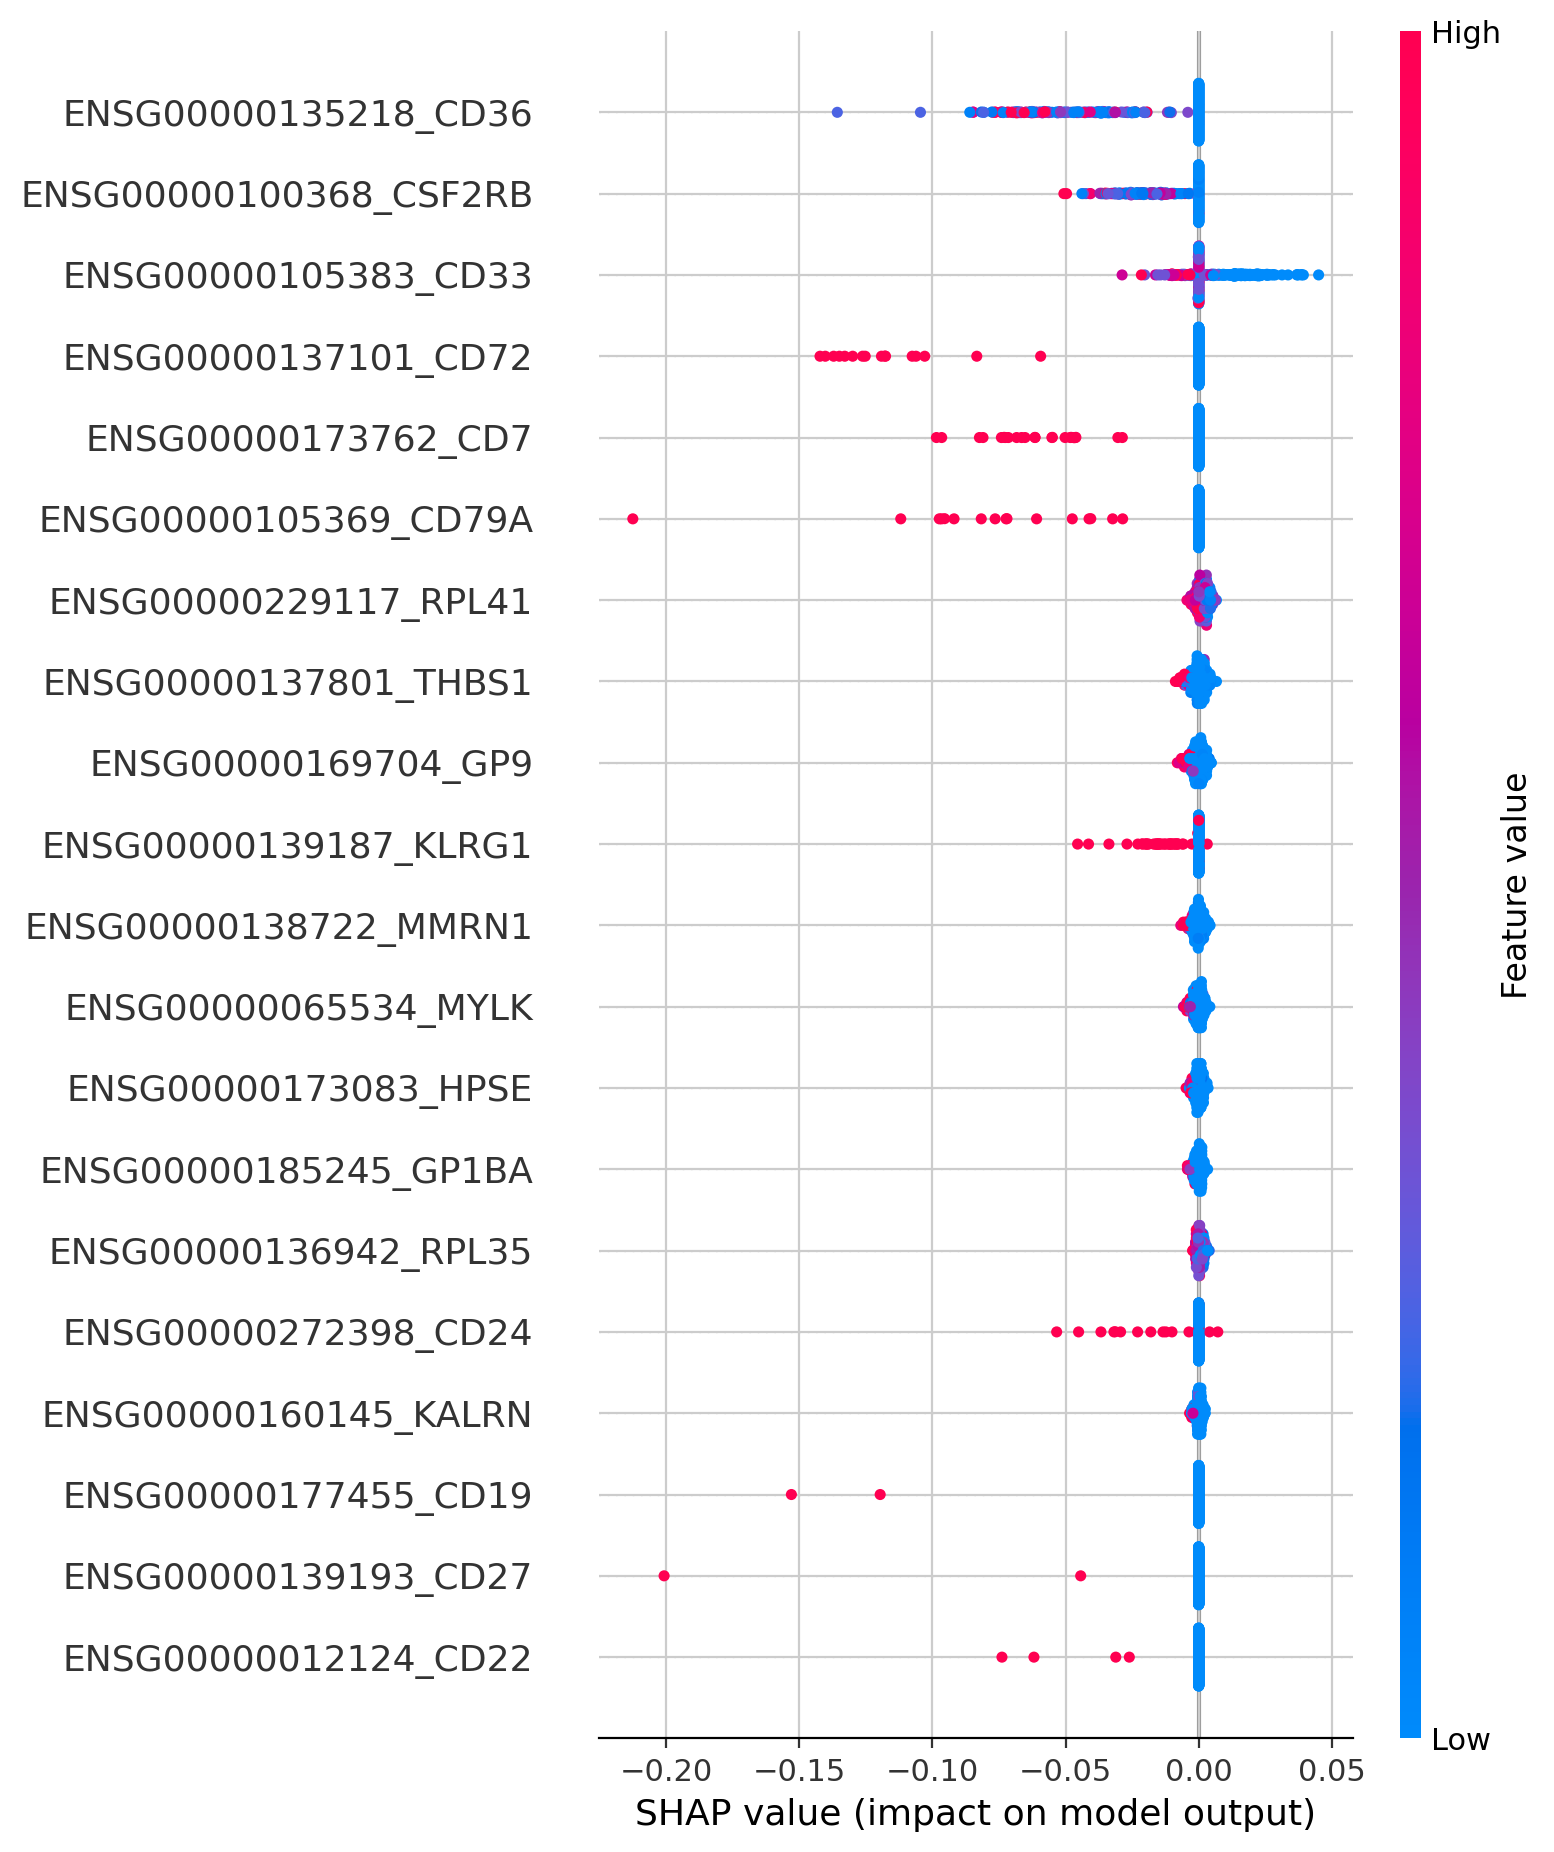

In [65]:
bottom_20 = list(pd.DataFrame(corrs, index=xtest_all_genes.columns).sort_values(by=0, ascending=False).dropna().index[-20:])
idx = get_protein_idx('CD86')
subset = attr_all_22085_genes[idx][bottom_20]
shap.initjs()
shap.summary_plot(np.array(subset), xtest_all_genes[subset.columns], feature_names=subset.columns)

In [66]:
from utils import enrich

In [67]:
enrich([x.split('_')[1] for x in top_20], [x.split('_')[1] for x in all_22001_genes])

name   p_value  \
0    post-transcriptional regulation of gene expres...  0.001305   
1                       polyamine biosynthetic process  0.021747   
2                          polyamine metabolic process  0.024328   
3         cellular nitrogen compound metabolic process  0.027520   
4                  biogenic amine biosynthetic process  0.027520   
..                                                 ...       ...   
111                          ncRNA export from nucleus  0.048155   
112            regulation of translational termination  0.048155   
113                                     nuclear export  0.048155   
114                  establishment of RNA localization  0.048155   
115  microtubule cytoskeleton organization involved...  0.049426   

                                         intersections  
0              [SERBP1, RAN, C1QBP, EIF5A, NCL, PA2G4]  
1                                          [ODC1, SRM]  
2                                          [ODC1, SRM]  
3    [SERBP1, RAN, C1QBP, EIF5A, ODC1, SNRPD1, CCT6...  
4                                          [ODC1, SRM]  
..                                                 ...  
111                                              [SSB]  
112                                            [EIF5A]  
113                                         [RAN, SSB]  
114                                         [RAN, SSB]  
115                                        [RAN, NUDC]  

[116 rows x 3 columns]

In [68]:
enrich([x.split('_')[1] for x in bottom_20], [x.split('_')[1] for x in all_22001_genes])

name       p_value  \
0              regulation of wound healing  2.031998e-07   
1          regulation of body fluid levels  2.031998e-07   
2       regulation of response to wounding  2.608275e-07   
3                            wound healing  4.566566e-07   
4                              coagulation  1.022490e-06   
..                                     ...           ...   
250   regulation of cellular extravasation  4.967586e-02   
251  positive regulation of cell migration  4.967586e-02   
252               response to testosterone  4.967586e-02   
253          monoatomic cation homeostasis  4.967586e-02   
254                        gene expression  4.967586e-02   

                               intersections  
0          [HPSE, MMRN1, GP1BA, MYLK, THBS1]  
1    [HPSE, MMRN1, GP1BA, GP9, KALRN, THBS1]  
2          [HPSE, MMRN1, GP1BA, MYLK, THBS1]  
3     [HPSE, MMRN1, GP1BA, GP9, MYLK, THBS1]  
4           [HPSE, MMRN1, GP1BA, GP9, THBS1]  
..                                       ...  
250                                  [GP1BA]  
251                            [MYLK, THBS1]  
252                                  [THBS1]  
253                             [GP1BA, GP9]  
254  [HPSE, GP1BA, RPL35, GP9, RPL41, THBS1]  

[255 rows x 3 columns]

#### Plots per cell type

X converted to numpy array with dtype float64
The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


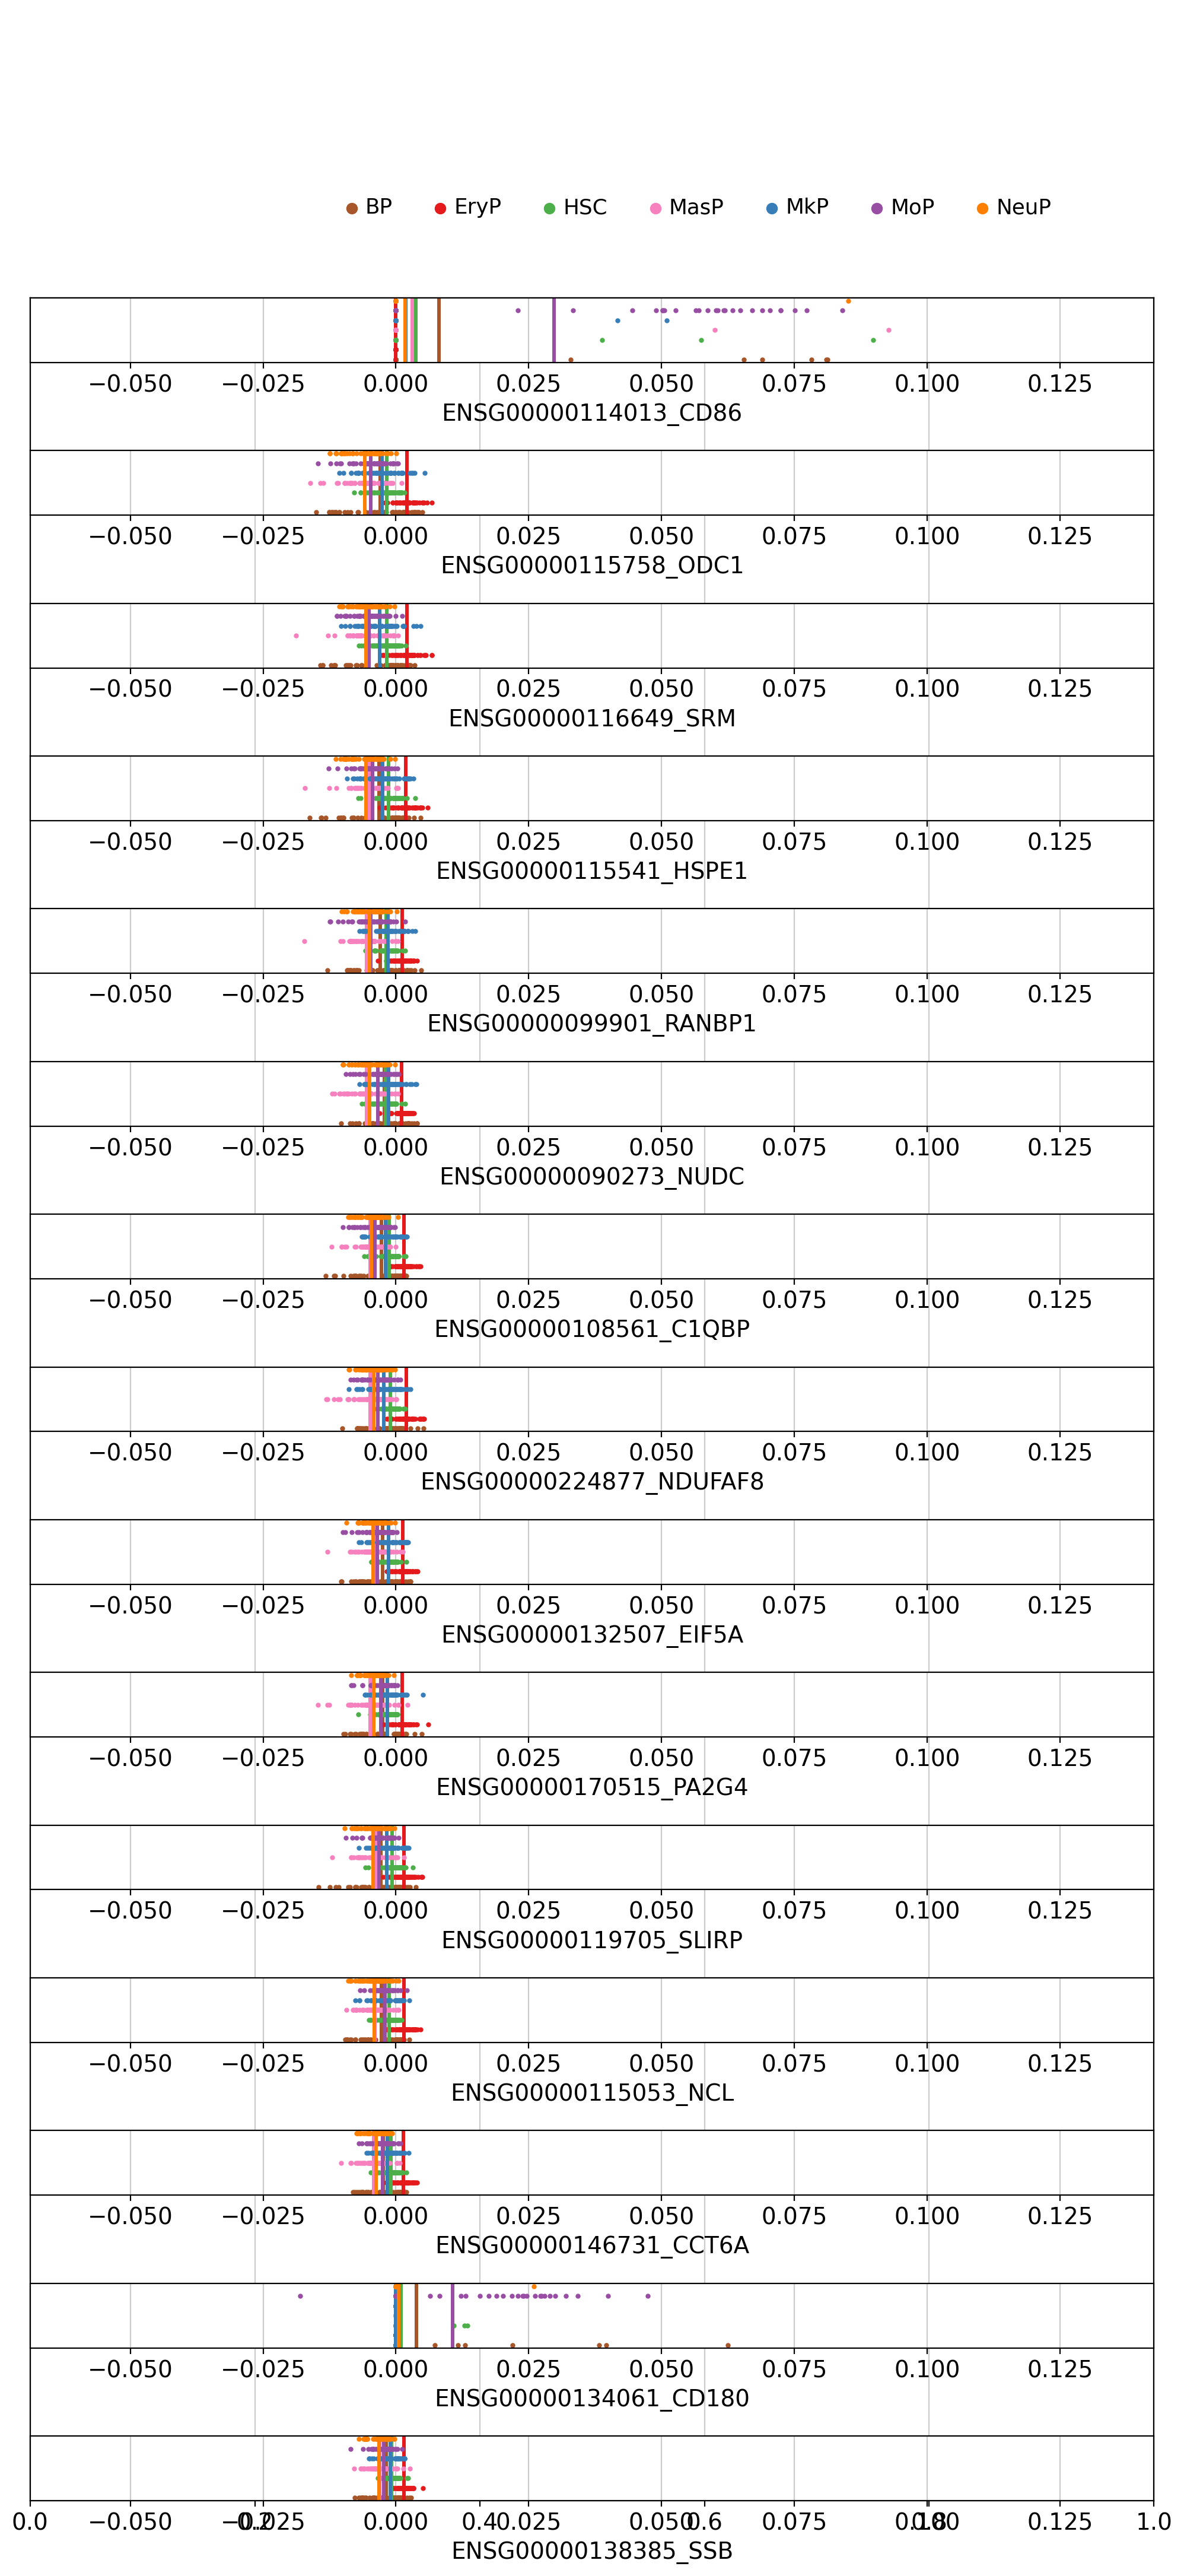

In [109]:
get_plot_per_cell_type(
    {idx: attr_all_22085_genes[idx][top_20]},
    ad.AnnData(X=xtest_all_genes, obs=xtest.obs, dtype=xtest_all_genes[top_20].dtypes),
    idx, n=15, all_attr=True)  #, save=True, filename='attr_16_50_samples_p', all_attr=True)

X converted to numpy array with dtype float64
The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


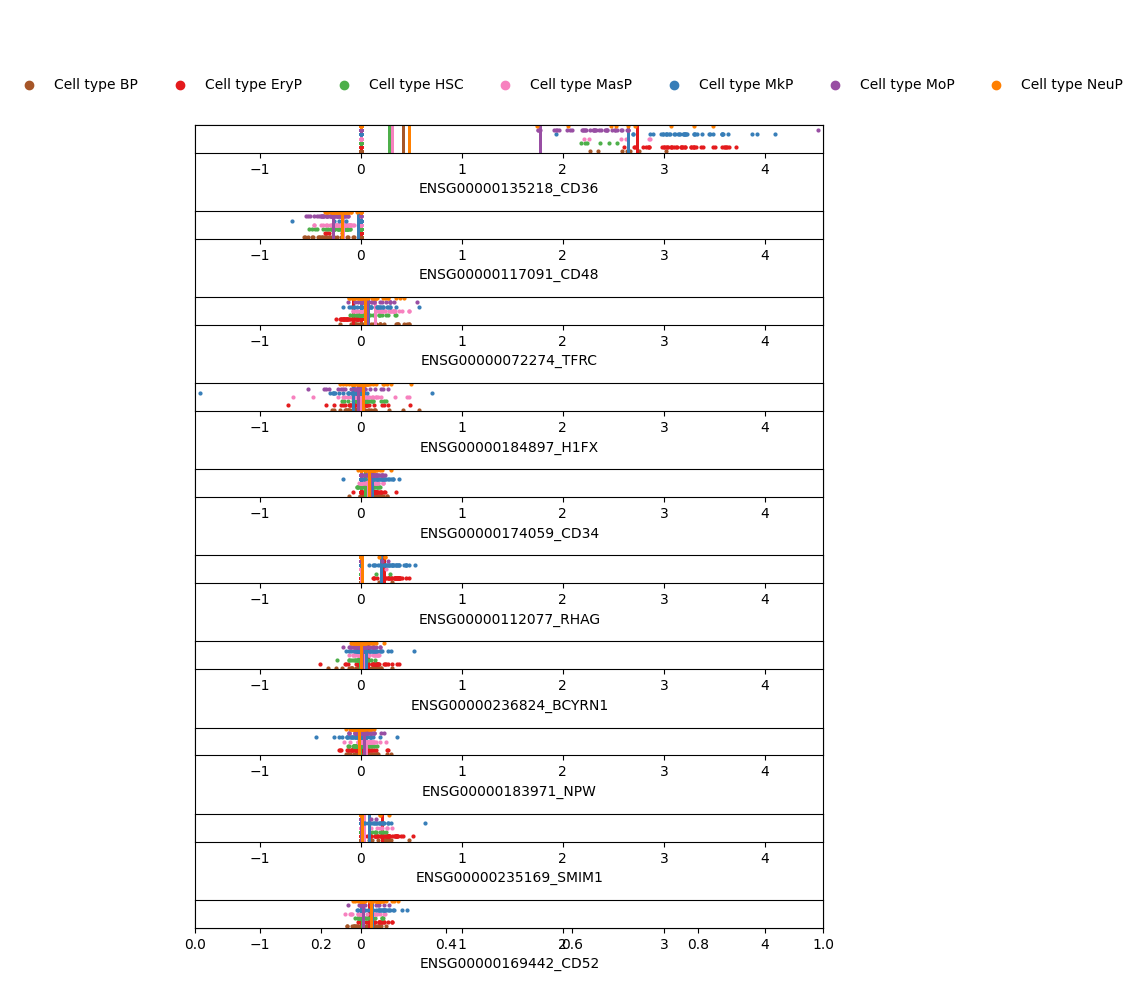

In [44]:
get_plot_per_cell_type(attr_all_22085_genes, ad.AnnData(X=xtest_all_genes, obs=xtest.obs, dtype=xtest_all_genes.dtypes), get_protein_idx('CD36'), all_attr=True)  #, save=True, filename='attr_16_50_samples_p', all_attr=True)

X converted to numpy array with dtype float64
The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


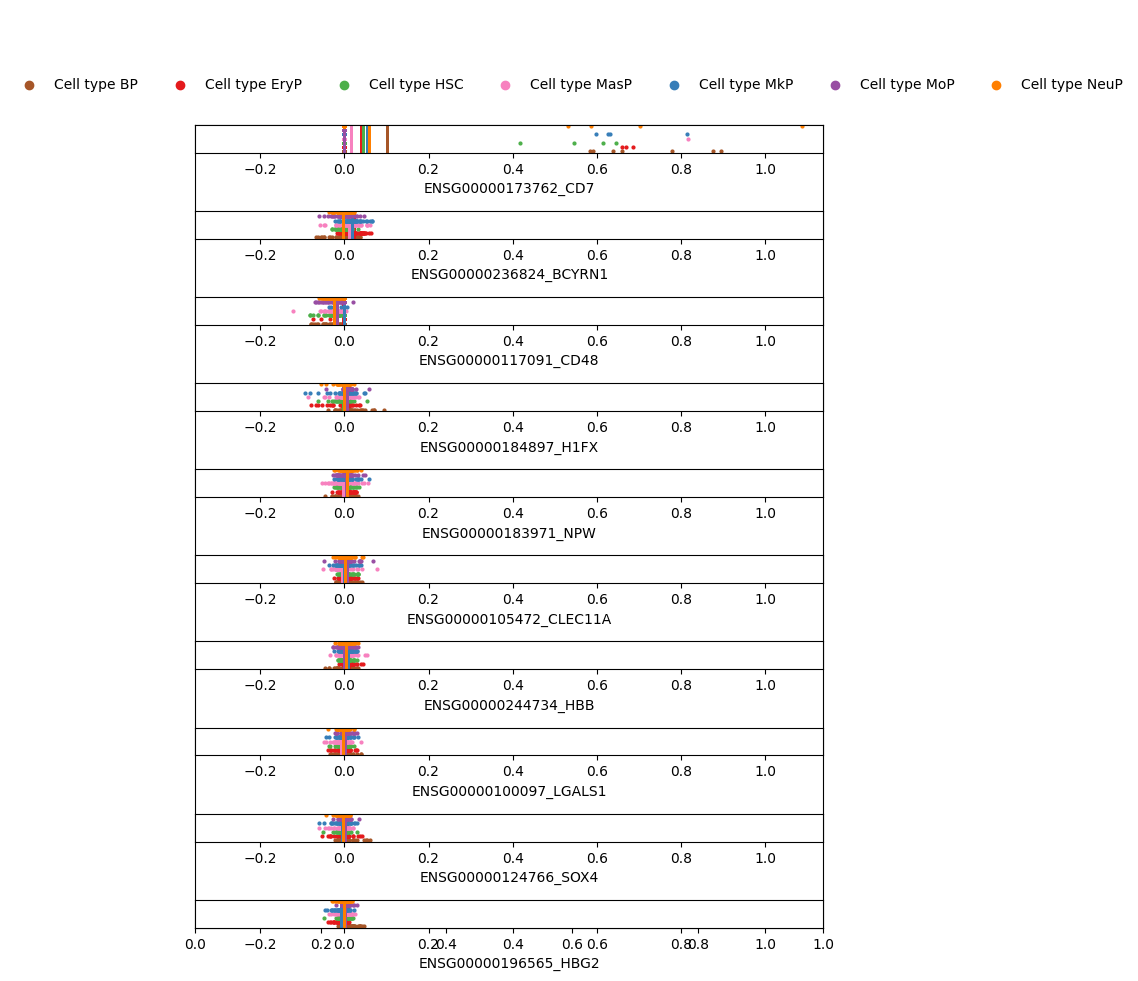

In [45]:
get_plot_per_cell_type(attr_all_22085_genes, ad.AnnData(X=xtest_all_genes, obs=xtest.obs, dtype=xtest_all_genes.dtypes), get_protein_idx('CD7'), all_attr=True)  #, save=True, filename='attr_16_50_samples_p', all_attr=True)

In [22]:
# get top 20 features (see shap beeswarm plot)
top_20 = get_top_features(attr_all_22085_genes[0], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20)
print(top_20)
# np.save('4.model/pred/top_feature_names_16_p.npy', top_20)

Index(['ENSG00000135218_CD36', 'ENSG00000010278_CD9', 'ENSG00000100097_LGALS1',
       'ENSG00000183971_NPW', 'ENSG00000105472_CLEC11A',
       'ENSG00000184897_H1FX', 'ENSG00000100368_CSF2RB',
       'ENSG00000265972_TXNIP', 'ENSG00000122862_SRGN', 'ENSG00000105205_CLC',
       'ENSG00000236824_BCYRN1', 'ENSG00000125148_MT2A',
       'ENSG00000077984_CST7', 'ENSG00000245532_NEAT1', 'ENSG00000124766_SOX4',
       'ENSG00000244734_HBB', 'ENSG00000005381_MPO', 'ENSG00000101745_ANKRD12',
       'ENSG00000163191_S100A11', 'ENSG00000105383_CD33'],
      dtype='object', name='gene_ids')


X converted to numpy array with dtype float64


#### check why some genes ranked low

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


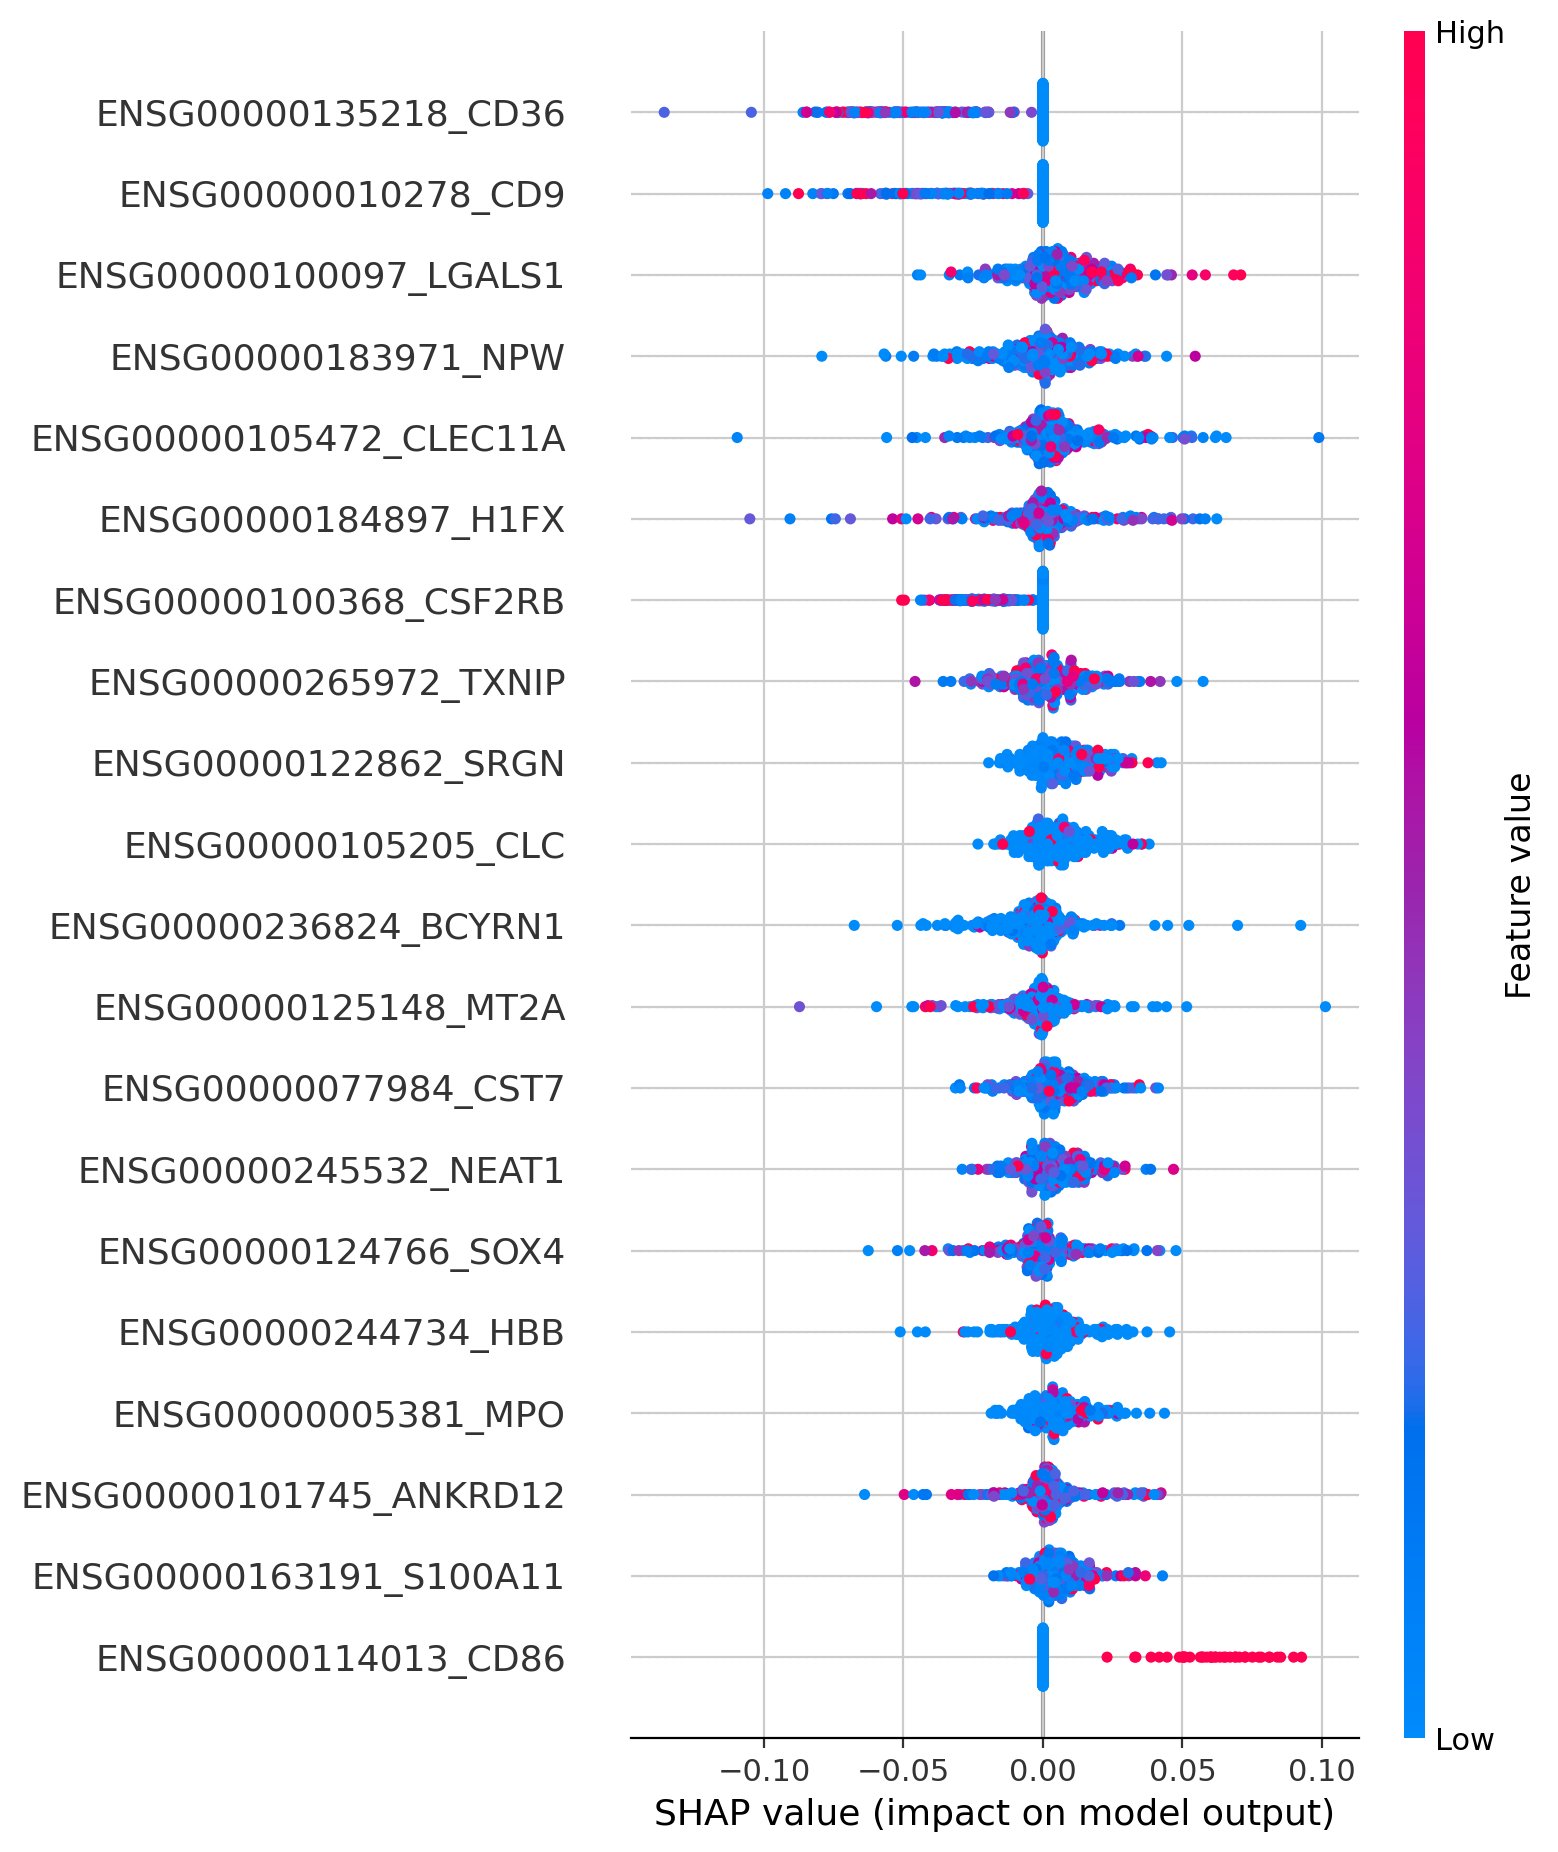

In [23]:
# subset attr_all_22085_genes: any 19 plus the column we want
# force plot to show specific column
# see why 86 ranked low
idx = get_protein_idx('CD86')
top_19 = get_top_features(attr_all_22085_genes[idx], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 19)
corresp_gene = [col for col in attr_all_22085_genes[idx].columns if col.endswith('CD86')]
subset = attr_all_22085_genes[idx][list(top_19)+corresp_gene]
shap.initjs()
shap.summary_plot(np.array(subset), xtest_all_genes[subset.columns], feature_names=subset.columns)

X converted to numpy array with dtype float64


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


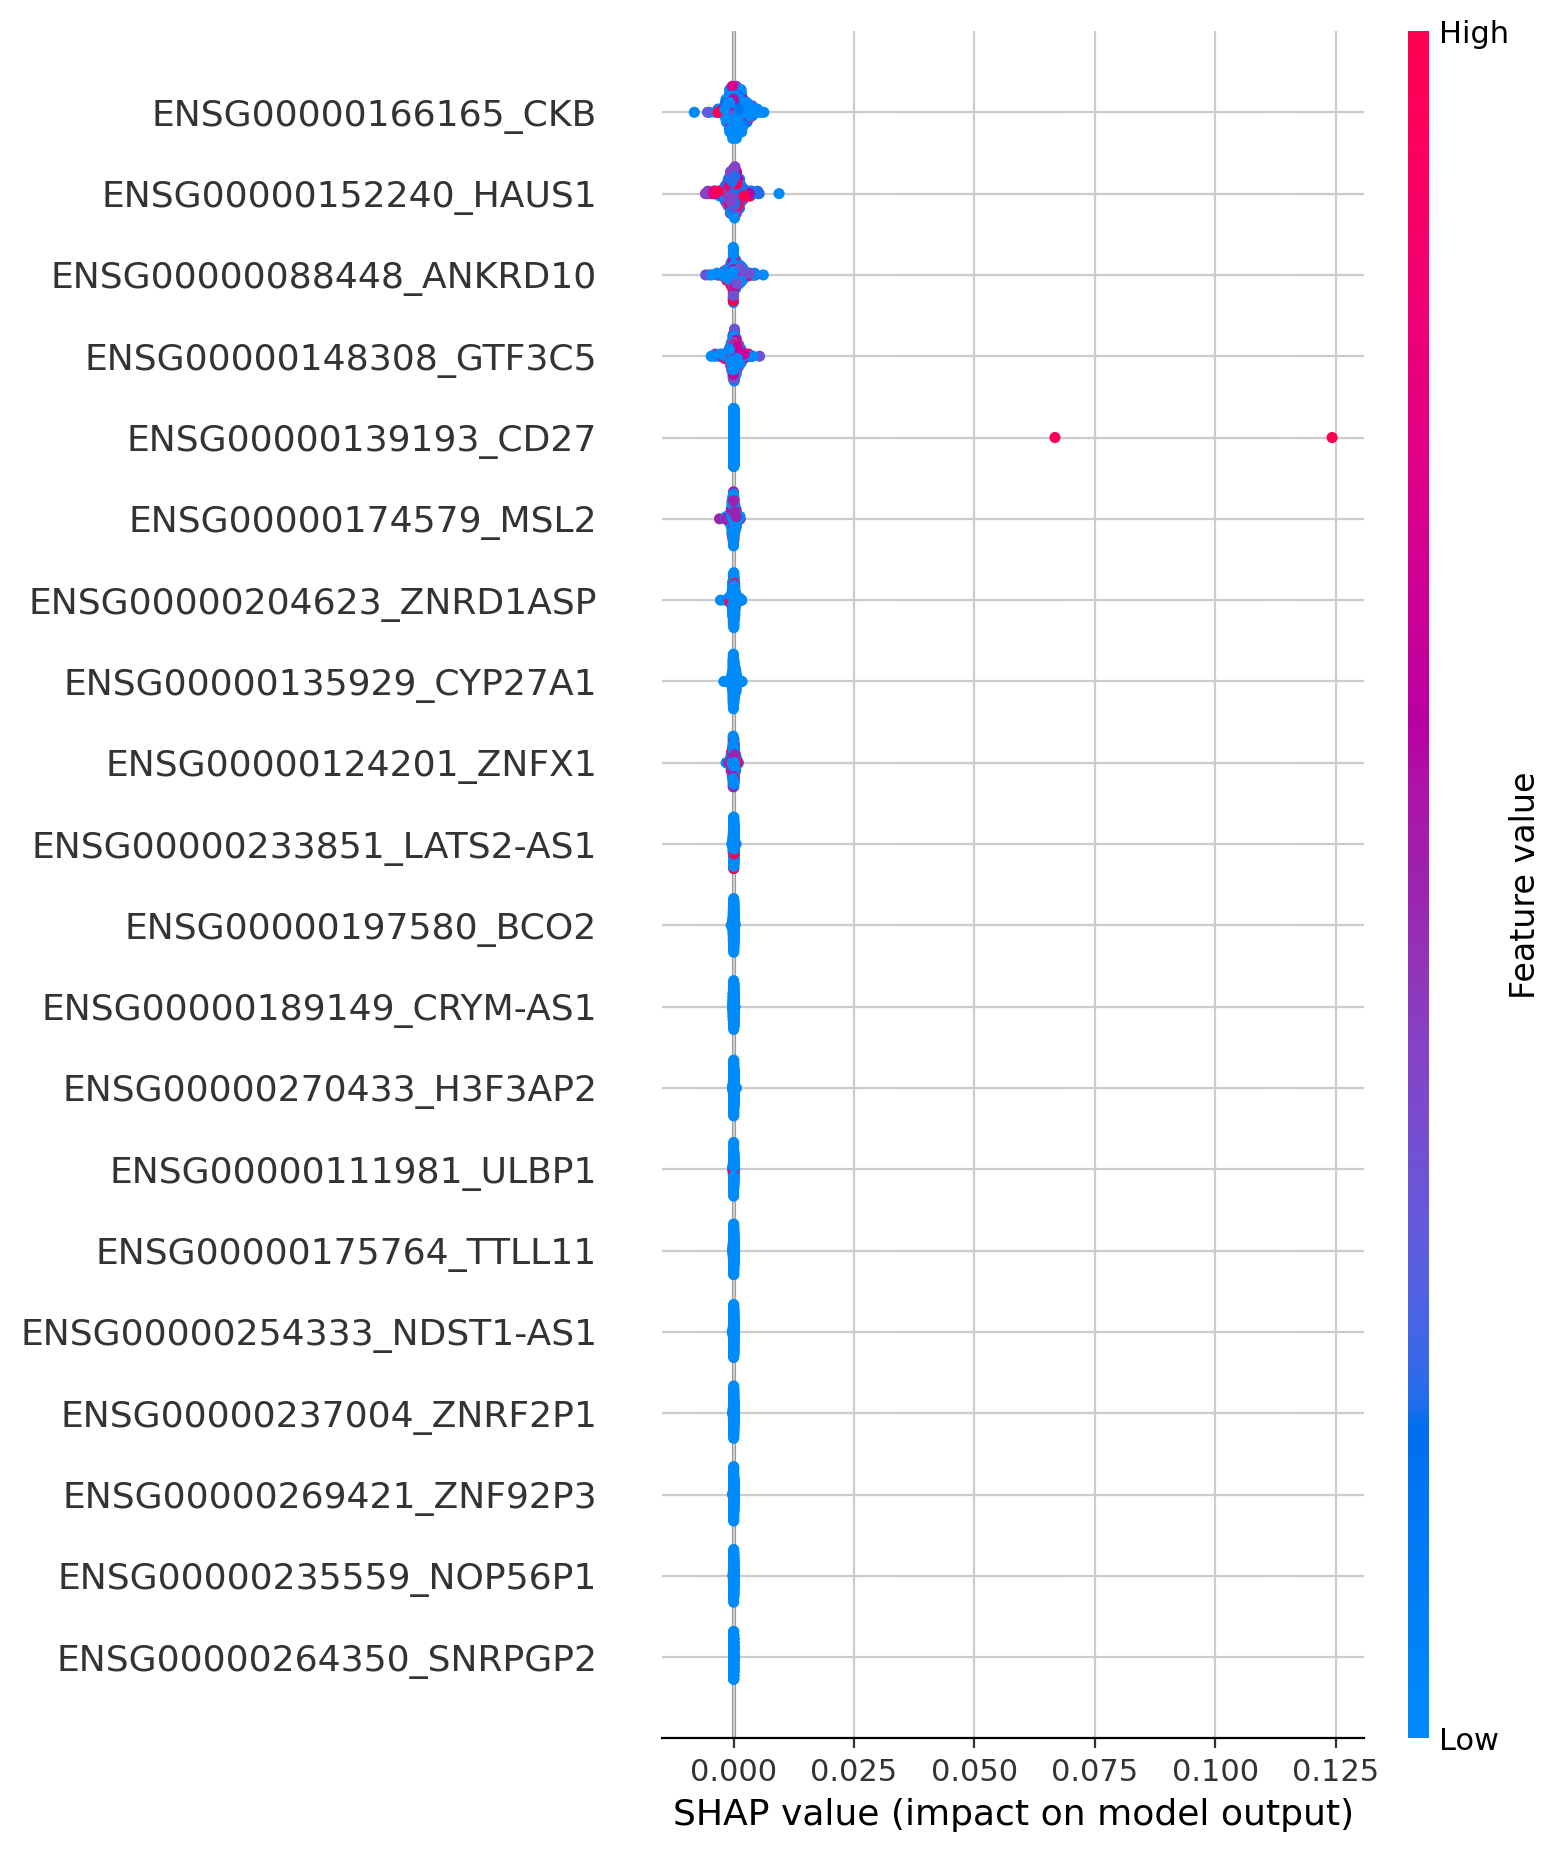

In [24]:
# see why 27 ranked low
idx = get_protein_idx('CD27')
top_19 = get_top_features(attr_all_22085_genes[idx], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 19)
corresp_gene = [col for col in attr_all_22085_genes[idx].columns if col.endswith('CD27')]
subset = attr_all_22085_genes[idx][list(top_19)+corresp_gene]
shap.initjs()
shap.summary_plot(np.array(subset), xtest_all_genes[subset.columns], feature_names=subset.columns)

In [25]:
top_19 = get_top_features(attr_all_22085_genes[get_protein_idx('CD9')], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 19)
top_19

X converted to numpy array with dtype float64


Index(['ENSG00000237004_ZNRF2P1', 'ENSG00000269421_ZNF92P3',
       'ENSG00000148308_GTF3C5', 'ENSG00000088448_ANKRD10',
       'ENSG00000235559_NOP56P1', 'ENSG00000264350_SNRPGP2',
       'ENSG00000111981_ULBP1', 'ENSG00000228049_POLR2J2',
       'ENSG00000233851_LATS2-AS1', 'ENSG00000167397_VKORC1',
       'ENSG00000117676_RPS6KA1', 'ENSG00000123119_NECAB1',
       'ENSG00000149929_HIRIP3', 'ENSG00000175764_TTLL11',
       'ENSG00000047346_FAM214A', 'ENSG00000049239_H6PD',
       'ENSG00000127191_TRAF2', 'ENSG00000101333_PLCB4',
       'ENSG00000167995_BEST1'],
      dtype='object', name='gene_ids')

In [26]:
# force plotting top features of model 16 using attributions for model 17 (after running attr_..._17)
idx = get_protein_idx('CD9')
top_19 = get_top_features(attr_all_22085_genes[idx], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 19)
subset = attr_all_22085_genes_17[idx][list(top_19)]
shap.initjs()
shap.summary_plot(np.array(subset), xtest_all_genes[subset.columns], feature_names=subset.columns)

NameError: name 'attr_all_22085_genes_17' is not defined

### plots for model #17

In [51]:
# shap_values = np.load('4.model/pred/shap_values_17_50_samples_p.npy', allow_pickle=True).astype(float)
xtest_17 = ad.read_h5ad('4.model/pred/private_test_input_64_svd_50_samples.h5ad')
# xtest_17

In [ ]:
# shap_beeswarm(shap_values, xtest)   # only svd components
# goal: get this plot as SHAP / features instead of SHAP / SVD components + features

#### shap plot with backpropagated gene attributions

In [ ]:
attr_all_22085_genes_17 = pd.read_pickle(lrz_path + 'large_preprocessed_files/attr_all_genes/attr_all_22085_genes_17_50_samples_p_ct_distr.pkl')
attr_all_22085_genes_17[0].head(2)

In [ ]:
attr_beeswarm(attr_all_22085_genes_17, xtest_all_genes, get_protein_idx('CD4'))
# 121: maybe: model 17 checks if CD9 important at all (binary), model 16 gives actual value

In [ ]:
# get top 20 features (see shap beeswarm plot)
# top_20 = get_top_features(attr_all_22085_genes_17[0], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 20) 
# print(top_20)
# np.save('4.model/pred/top_feature_names_17_p.npy', top_20)

In [ ]:
get_plot_per_cell_type(attr_all_22085_genes_17, ad.AnnData(X=xtest_all_genes, obs=xtest_17.obs, dtype=xtest_all_genes.dtypes), get_protein_idx('CD9'), all_attr=True)  #, save=True, filename='attr_17_50_samples_p', all_attr=True)

#### check why some genes ranked low

In [ ]:
# subset attr_all_22085_genes: any 19 plus the column we want
# force plot to show specific column
# see why 86 ranked low
idx = get_protein_idx('CD4')
top_9 = get_top_features(attr_all_22085_genes_17[idx], ad.AnnData(xtest_all_genes, dtype=xtest_all_genes.dtypes), 9)
subset = attr_all_22085_genes_17[idx][list(top_9)+get_gene_name('CD4')]
shap.initjs()
shap.summary_plot(np.array(subset), xtest_all_genes[subset.columns], feature_names=subset.columns)

In [ ]:
get_plot_per_cell_type([subset], ad.AnnData(X=xtest_all_genes[subset.columns], obs=xtest_17.obs, dtype=xtest_all_genes[subset.columns].dtypes), all_attr=False)

### plots for ensemble of model 16 and 17

In [ ]:
# weighted sum of attribution datasets of model 16 and 17
attr_16_17 = {}

for key in range(140):
    # Add the dataframes element-wise if the key(==protein index) exists in both dictionaries
    if key in attr_all_22085_genes and key in attr_all_22085_genes_17:
        weighted_sum = 0.5 * attr_all_22085_genes[key] + 0.5 * attr_all_22085_genes_17[key]
        attr_16_17[key] = weighted_sum

In [ ]:
 attr_beeswarm(attr_16_17, xtest_all_genes, get_protein_idx('CD9'))

In [ ]:
get_plot_per_cell_type(attr_16_17, ad.AnnData(X=xtest_all_genes, obs=xtest_17.obs, dtype=xtest_all_genes.dtypes), get_protein_idx('CD9'), all_attr=True)  #, save=True, filename='attr_17_50_samples_p', all_attr=True)

### get cell type plot for a specific gene and compare across models

In [ ]:
get_ct_plot_compare(attr_all_22085_genes, attr_all_22085_genes_17, attr_16_17, 
                    ad.AnnData(X=xtest_all_genes, obs=xtest.obs, dtype=xtest_all_genes.dtypes), 
                    get_protein_idx('CD9'), 'NPW')